<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
(x, y), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
x = np.expand_dims(x, axis=-1)
x = (x - 127.5) / 127.5
x.shape, x.min(), x.max()

((60000, 28, 28, 1), -1.0, 1.0)

In [8]:
buffer_size=x.shape[0]
batch_size=256

In [9]:
x = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)

In [10]:
x

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

#Generator

In [11]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Reshape((7, 7, 256)))

  network.add(tf.keras.layers.Conv2DTranspose(128, 5, padding='same', use_bias=False))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh'))

  network.summary()
  return network

In [12]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [13]:
noise = tf.random.normal((1, 100))

In [14]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.30782148,  0.7302129 , -1.1990811 , -0.4213277 ,  1.1100484 ,
         1.4224571 ,  0.6566732 ,  0.7504005 ,  0.07845496, -1.8497941 ,
        -0.19773577, -0.67803085,  0.7665721 , -0.63106817,  0.64483756,
        -1.3666557 , -2.1427672 , -0.06148845,  0.79017055, -0.95017993,
         0.67751974,  0.9430464 , -1.7420646 , -1.0147426 ,  1.1689572 ,
        -0.41500115,  0.90472704, -0.44750273,  1.593575  ,  0.67036825,
        -0.43121153,  0.7057064 ,  1.0637403 , -0.5193298 ,  0.8256245 ,
         2.8866136 , -0.8847381 ,  0.17457849, -1.0577023 , -1.0284861 ,
        -0.37535992,  0.13101518, -0.40291867,  0.3586956 , -0.6170585 ,
         0.9170026 ,  0.8063689 ,  0.24600103,  0.22891487,  1.2850709 ,
         0.47793564, -0.9463882 ,  0.91291946,  0.78941786, -1.0202273 ,
        -1.8001038 , -1.7347554 , -0.84458035,  0.596528  ,  2.1509054 ,
         0.1405076 ,  0.36249968,  0.03729421,  0.7170112 ,  0.31567374,
 

In [15]:
generated_img = generator(noise, training=False)
generated_img.shape

TensorShape([1, 28, 28, 1])

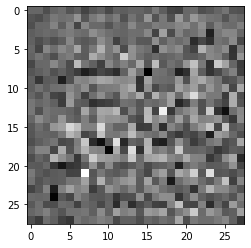

In [16]:
plt.imshow(generated_img[0, :, :, 0], cmap='gray')

#Discriminator

In [17]:
def build_discriminator():
  network = tf.keras.Sequential()

  network.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)))
  network.add(tf.keras.layers.Dropout(0.3))
  network.add(tf.keras.layers.LeakyReLU())

  network.add(tf.keras.layers.Conv2D(128, 5, padding='same'))
  network.add(tf.keras.layers.Dropout(0.3))
  network.add(tf.keras.layers.LeakyReLU())

  network.add(tf.keras.layers.Flatten())
  network.add(tf.keras.layers.Dense(1))

  network.summary()

  return network

In [18]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)            

In [19]:
discriminator(generated_img, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00139575]], dtype=float32)>

#Loss

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [22]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

#Train

In [41]:
epochs = 10
noise_dim = 100
num_image_to_generate = 16
batch_size = 256

In [42]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_images = generator(noise, training=True)

    expected_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)
  
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [44]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for i, image_batch in enumerate(dataset):
      print(i)
      train_steps(image_batch)
    
    print(f'Epoch --- {epoch}')
    generated_images = generator(test_images, training=False)
    fog = plt.figure(figsize=(10, 10))
    print(generated_images.shape[0])
    for k in range(num_image_to_generate):
      plt.subplot(4, 4, k+1)
      plt.imshow(generated_images[k, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
Epoch --- 0
256


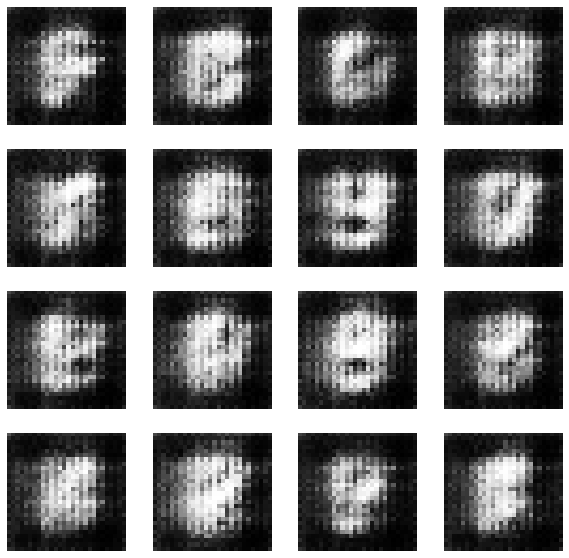

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
Epoch --- 1
256


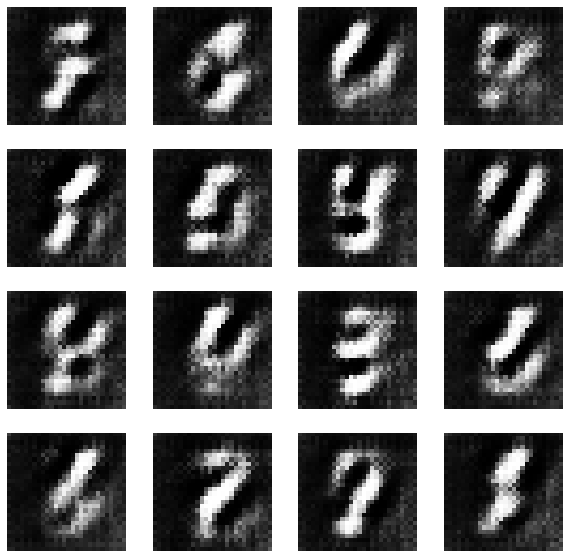

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
Epoch --- 2
256


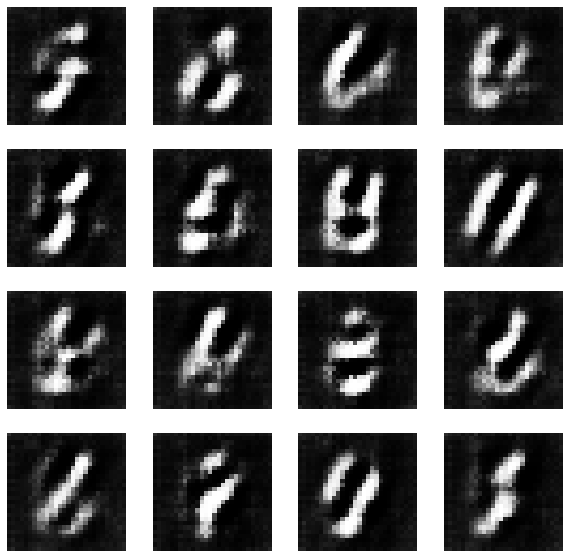

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
Epoch --- 3
256


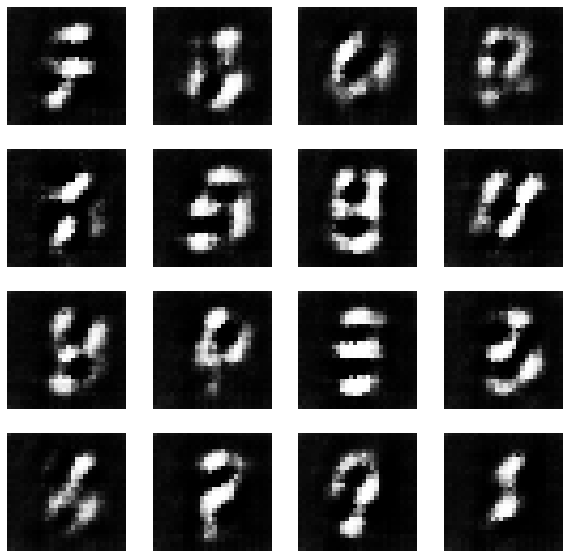

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
Epoch --- 4
256


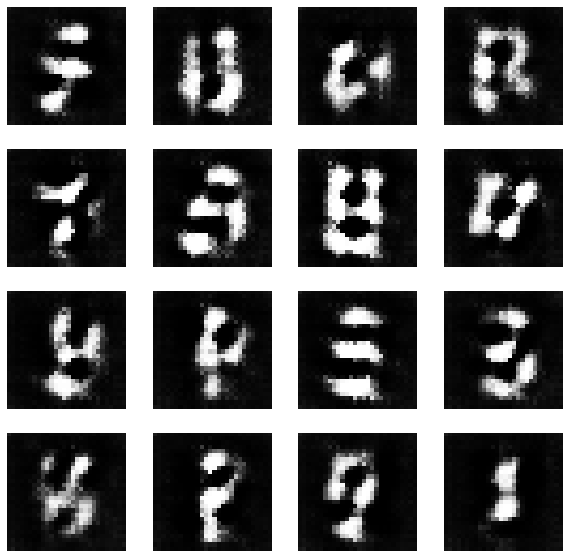

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
test_images = tf.random.normal([batch_size, noise_dim])
train(x, epochs, test_images)

In [ ]:
vbf